# Data Loading and Preprocessing Pipeline Demo

This notebook demonstrates the complete data preprocessing pipeline for shuttle tracking data:
1. Load vehicle locations from database/CSV
2. Convert timestamps to epoch seconds
3. Add closest route information
4. Compute distance deltas
5. Compute speed
6. Segment into consecutive trips
7. Visualize speed over time for a single segment

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import preprocessing functions
from ml.pipelines import segment_pipeline
from ml.data.preprocess import segment_by_consecutive

## Step 1: Load and Preprocess Data

The `preprocess_pipeline()` function runs all preprocessing steps and caches the result.

In [72]:
# Load preprocessed data (uses cache if available)
df = segment_pipeline()

print(f"Loaded {len(df)} location points")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData shape: {df.shape}")

Loading segmented data from /Users/joel/eclipse-workspace/shuttletracker-new/ml/cache/shared/locations_segmented_max_distance0p005_max_timedelta15_min_segment_length3_window_size5.csv
Loaded 1435917 records from cache
Loaded 1435917 location points

Columns: ['vehicle_id', 'latitude', 'longitude', 'timestamp', 'epoch_seconds', 'dist_to_route', 'route', 'closest_lat', 'closest_lon', 'polyline_idx', 'segment_idx', 'segment_id', 'distance_km', 'speed_kmh']

Data shape: (1435917, 14)


In [73]:
# Display first few rows
df.head(20)

,vehicle_id,latitude,longitude,timestamp,epoch_seconds,dist_to_route,route,closest_lat,closest_lon,polyline_idx,segment_idx,segment_id,distance_km,speed_kmh
0,212014918466445,42.731380,-73.677000,2025-08-23 18:22:51.001,2.028377e+07,0.003282,NORTH,42.731390,-73.677037,7.0,26.0,1,NaN,NaN
1,212014918466445,42.731065,-73.677094,2025-08-23 18:22:56.134,2.028378e+07,0.002943,NORTH,42.731075,-73.677128,7.0,26.0,1,0.035847,25.140894
2,212014918466445,42.730903,-73.677111,2025-08-23 18:23:02.038,2.028378e+07,NaN,NORTH,NaN,NaN,7.0,NaN,1,NaN,NaN
3,212014918466445,42.730867,-73.677149,2025-08-23 18:23:16.052,2.028380e+07,NaN,NORTH,NaN,NaN,7.0,NaN,1,NaN,NaN
4,212014918466445,42.730865,-73.677149,2025-08-23 18:23:23.566,2.028380e+07,NaN,NORTH,NaN,NaN,7.0,NaN,1,NaN,NaN
5,212014918466445,42.730785,-73.677153,2025-08-23 18:23:36.056,2.028382e+07,NaN,NORTH,NaN,NaN,7.0,NaN,1,NaN,NaN
6,212014918466445,42.730805,-73.677164,2025-08-23 18:24:18.054,2.028386e+07,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
7,212014918466445,42.730752,-73.677155,2025-08-23 18:24:24.259,2.028386e+07,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
8,212014918466445,42.730657,-73.676987,2025-08-23 18:24:36.004,2.028388e+07,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
9,212014918466445,42.730692,-73.676854,2025-08-23 18:24:41.041,2.028388e+07,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN


In [74]:
# Display rows surrounding largest speed
max_speed_idx = df['speed_kmh'].idxmax()
start_idx = max(0, max_speed_idx - 5)
end_idx = min(len(df), max_speed_idx + 6)
df.iloc[start_idx:end_idx]

,vehicle_id,latitude,longitude,timestamp,epoch_seconds,dist_to_route,route,closest_lat,closest_lon,polyline_idx,segment_idx,segment_id,distance_km,speed_kmh
415486,281474978656308,42.732379,-73.671353,2025-10-10 20:09:01.034,2.443734e+07,0.001941,NORTH,42.732362,-73.671355,7.0,9.0,126467,0.029609,21.564575
415487,281474978656308,42.732405,-73.671480,2025-10-10 20:09:10.164,2.443735e+07,NaN,NORTH,NaN,NaN,7.0,NaN,126467,NaN,NaN
415488,281474978656308,42.732404,-73.671482,2025-10-10 20:09:22.084,2.443736e+07,NaN,NORTH,NaN,NaN,7.0,NaN,126467,NaN,NaN
415489,281474978656308,42.732557,-73.672593,2025-10-10 20:09:32.034,2.443737e+07,0.003921,NORTH,42.732521,-73.672598,7.0,11.0,126467,NaN,NaN
415490,281474978656308,42.732704,-73.673691,2025-10-10 20:09:39.594,2.443738e+07,0.000096,NORTH,42.732703,-73.673691,7.0,15.0,126467,0.091534,43.587650
415491,281474978656308,42.732848,-73.674804,2025-10-10 20:09:43.982,2.443738e+07,0.000089,NORTH,42.732847,-73.674804,7.0,16.0,126467,0.092362,75.775889
415492,281474978656308,42.732957,-73.675540,2025-10-10 20:09:48.987,2.443739e+07,0.001503,NORTH,42.732943,-73.675542,7.0,18.0,126467,0.061164,43.993976
415493,281474978656308,42.730694,-73.676754,2025-10-10 20:19:49.943,2.443799e+07,NaN,NORTH,NaN,NaN,0.0,NaN,126477,NaN,NaN
415494,281474978656308,42.730694,-73.676754,2025-10-10 20:19:58.572,2.443800e+07,NaN,NORTH,NaN,NaN,0.0,NaN,126477,NaN,NaN
415495,281474978656308,42.730682,-73.676405,2025-10-10 20:20:10.021,2.443801e+07,NaN,NORTH,NaN,NaN,0.0,NaN,126477,NaN,NaN


## Step 2: Basic Data Summary

In [75]:
# Summary statistics
print("Summary Statistics:")
print("="*60)
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Number of vehicles: {df['vehicle_id'].nunique()}")

# Handle NaN values in route column
route_values = df['route'].dropna().unique()
print(f"Number of routes: {len(route_values)}")
print(f"\nRoutes: {sorted(route_values)}")

# Count NaN routes
nan_routes = df['route'].isna().sum()
print(f"Unmatched locations (no route): {nan_routes} ({nan_routes/len(df)*100:.2f}%)")

print(f"\nSpeed statistics (km/h):")
print(df['speed_kmh'].describe())

Summary Statistics:
Date range: 2025-07-31 15:55:27.052000 to 2025-12-25 01:21:50
Number of vehicles: 27
Number of routes: 2

Routes: ['NORTH', 'WEST']
Unmatched locations (no route): 154861 (10.78%)

Speed statistics (km/h):
count    705208.000000
mean         25.905478
std          14.021631
min           0.000000
25%          15.532534
50%          28.024512
75%          36.935780
max          75.775889
Name: speed_kmh, dtype: float64


## Step 3: Segment into Consecutive Trips

Segments are created based on:
- Vehicle ID changes
- Time gaps > max_timedelta seconds

In [76]:
# Segment the data with 5-minute maximum time gap
max_timedelta = 15
segmented_df = segment_by_consecutive(df, max_timedelta=max_timedelta, segment_column='segment_id')

num_segments = segmented_df['segment_id'].nunique()
print(f"Created {num_segments} segments with max time gap of {max_timedelta}s ({max_timedelta/60:.1f} minutes)")

# Segment size distribution
segment_sizes = segmented_df.groupby('segment_id').size()
print(f"\nSegment size statistics:")
print(segment_sizes.describe())

Created 115772 segments with max time gap of 15s (0.2 minutes)

Segment size statistics:
count    115772.000000
mean         12.402973
std          10.629717
min           3.000000
25%           5.000000
50%           9.000000
75%          16.000000
max         133.000000
dtype: float64


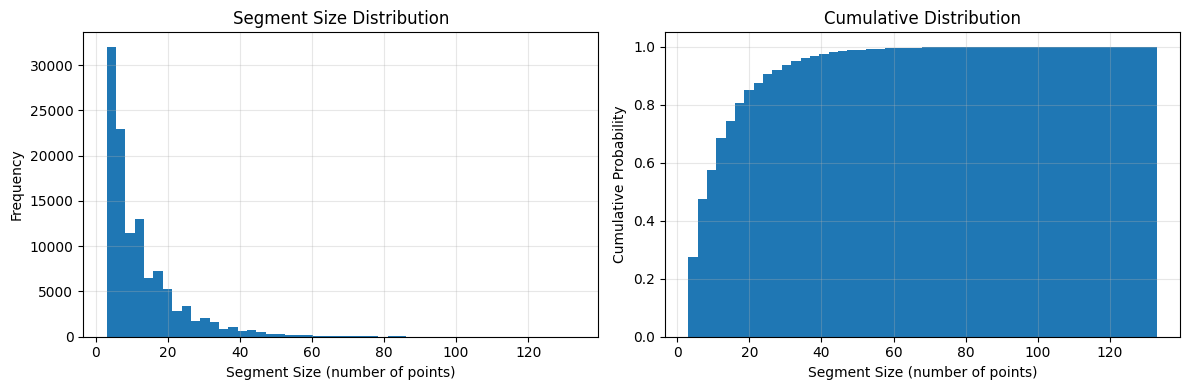


Segments with >= 10 points: 54787 (47.3%)
Segments with >= 20 points: 20529 (17.7%)
Segments with >= 50 points: 1454 (1.3%)


In [77]:
# Plot segment size distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
segment_sizes.hist(bins=50)
plt.xlabel('Segment Size (number of points)')
plt.ylabel('Frequency')
plt.title('Segment Size Distribution')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
segment_sizes.hist(bins=50, cumulative=True, density=True)
plt.xlabel('Segment Size (number of points)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSegments with >= 10 points: {(segment_sizes >= 10).sum()} ({(segment_sizes >= 10).sum() / len(segment_sizes) * 100:.1f}%)")
print(f"Segments with >= 20 points: {(segment_sizes >= 20).sum()} ({(segment_sizes >= 20).sum() / len(segment_sizes) * 100:.1f}%)")
print(f"Segments with >= 50 points: {(segment_sizes >= 50).sum()} ({(segment_sizes >= 50).sum() / len(segment_sizes) * 100:.1f}%)")

## Step 4: Select and Visualize One Segment

Let's select a segment with a reasonable number of points and visualize its speed over time.

In [78]:
# Filter to segments with valid routes (no NaN)
segmented_with_routes = segmented_df[segmented_df['route'].notna()].copy()
valid_segment_sizes = segmented_with_routes.groupby('segment_id').size()

# Find segments with at least 20 points for better visualization
large_segments = valid_segment_sizes[valid_segment_sizes >= 20].index

if len(large_segments) == 0:
    print("No segments with >= 20 points and valid routes found. Using largest valid segment.")
    selected_segment_id = valid_segment_sizes.idxmax()
else:
    # Select a segment from the middle of the dataset
    selected_segment_id = large_segments[len(large_segments) // 2]

# Extract the selected segment
segment = segmented_with_routes[segmented_with_routes['segment_id'] == selected_segment_id].copy()
segment = segment.sort_values('timestamp').reset_index(drop=True)

print(f"Selected segment {selected_segment_id}")
print(f"Number of points: {len(segment)}")
print(f"Vehicle ID: {segment['vehicle_id'].iloc[0]}")
print(f"Route: {segment['route'].iloc[0]}")
print(f"Time range: {segment['timestamp'].iloc[0]} to {segment['timestamp'].iloc[-1]}")
print(f"Duration: {(segment['timestamp'].iloc[-1] - segment['timestamp'].iloc[0]).total_seconds() / 60:.1f} minutes")

Selected segment 50280
Number of points: 28
Vehicle ID: 281474979530259
Route: WEST
Time range: 2025-08-29 18:41:28.052000 to 2025-08-29 18:44:42.044000
Duration: 3.2 minutes


In [79]:
# Display segment data
segment[['vehicle_id', 'timestamp', 'latitude', 'longitude', 'route', 'distance_km', 'speed_kmh', 'epoch_seconds']].head(10)

,vehicle_id,timestamp,latitude,longitude,route,distance_km,speed_kmh,epoch_seconds
0,281474979530259,2025-08-29 18:41:28.052,42.728097,-73.678057,WEST,NaN,NaN,2.080329e+07
1,281474979530259,2025-08-29 18:41:33.075,42.727948,-73.678107,WEST,NaN,NaN,2.080329e+07
2,281474979530259,2025-08-29 18:41:38.415,42.727967,-73.678103,WEST,NaN,NaN,2.080330e+07
3,281474979530259,2025-08-29 18:41:44.036,42.727946,-73.678102,WEST,NaN,NaN,2.080330e+07
4,281474979530259,2025-08-29 18:41:55.160,42.727174,-73.678081,WEST,NaN,NaN,2.080332e+07
5,281474979530259,2025-08-29 18:42:06.036,42.727027,-73.678110,WEST,0.017127,5.669115,2.080333e+07
6,281474979530259,2025-08-29 18:42:15.029,42.727030,-73.678097,WEST,0.000487,0.194954,2.080334e+07
7,281474979530259,2025-08-29 18:42:21.054,42.727016,-73.678099,WEST,0.001508,0.901142,2.080334e+07
8,281474979530259,2025-08-29 18:42:27.280,42.726743,-73.678131,WEST,0.030908,17.871502,2.080335e+07
9,281474979530259,2025-08-29 18:42:33.290,42.726148,-73.678306,WEST,0.067471,40.415379,2.080335e+07


## Step 5: Visualize Speed Over Time

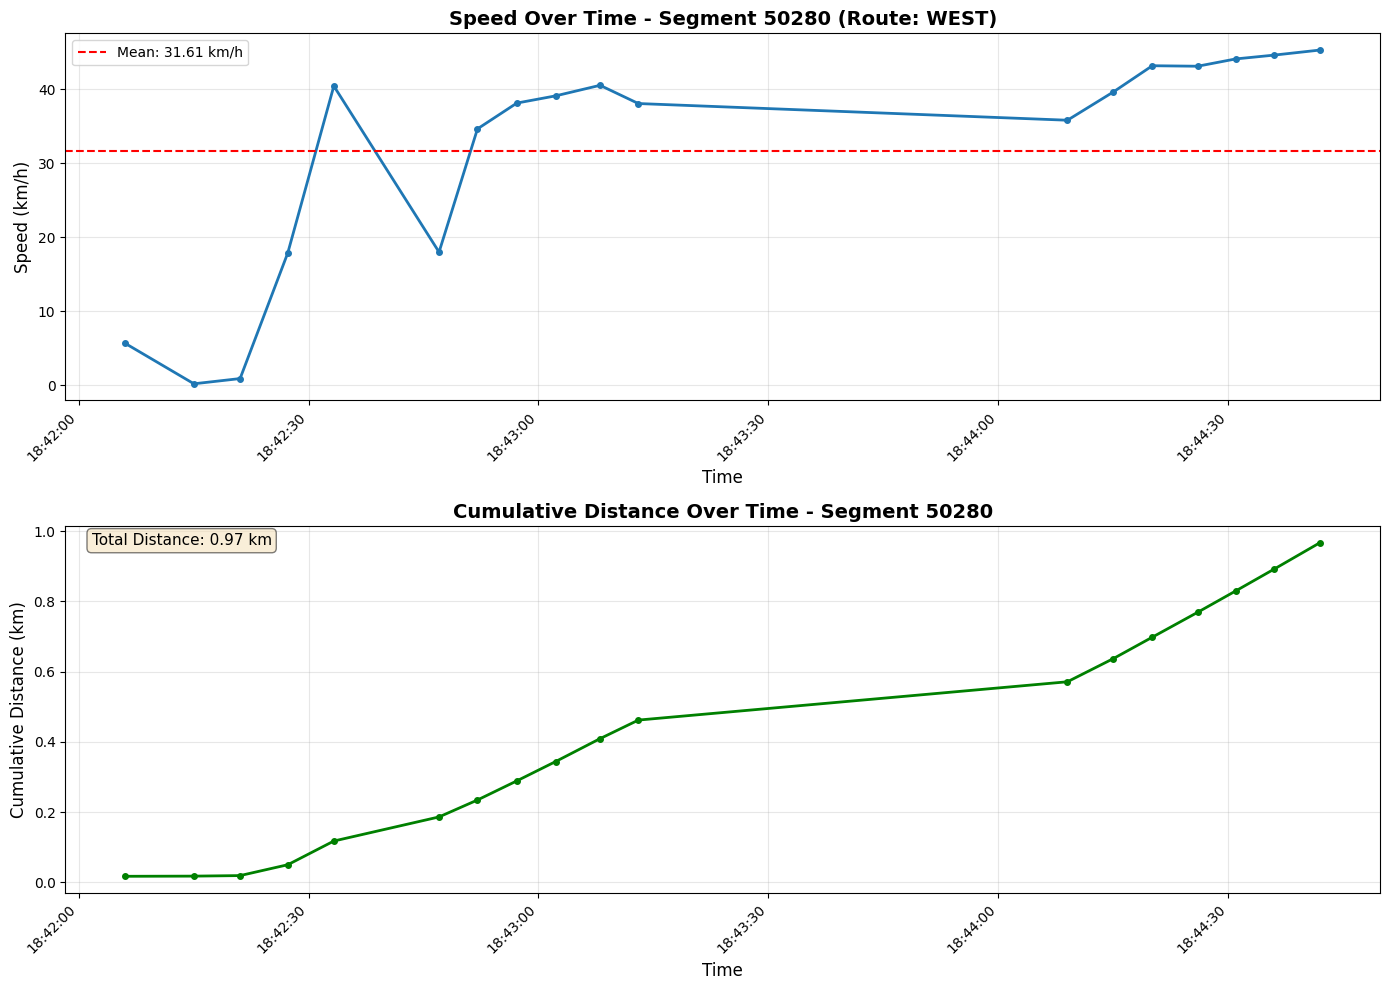


Speed Statistics for Segment 50280:
  Mean speed: 31.61 km/h
  Median speed: 38.60 km/h
  Max speed: 45.28 km/h
  Min speed: 0.19 km/h
  Std dev: 15.61 km/h
  Total distance: 0.97 km


In [80]:
# Create time-based plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Filter out NaN values for plotting
segment_clean = segment[segment['speed_kmh'].notna()].copy()

# Plot 1: Speed over time
ax1 = axes[0]
ax1.plot(segment_clean['timestamp'], segment_clean['speed_kmh'], marker='o', linestyle='-', linewidth=2, markersize=4)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Speed (km/h)', fontsize=12)
ax1.set_title(f'Speed Over Time - Segment {selected_segment_id} (Route: {segment["route"].iloc[0]})', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
mean_speed = segment_clean['speed_kmh'].mean()
ax1.axhline(y=mean_speed, color='r', linestyle='--', label=f'Mean: {mean_speed:.2f} km/h')
ax1.legend()

# Rotate x-axis labels for better readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Distance traveled over time (cumulative)
ax2 = axes[1]
cumulative_distance = segment_clean['distance_km'].cumsum()
ax2.plot(segment_clean['timestamp'], cumulative_distance, marker='o', linestyle='-', linewidth=2, markersize=4, color='green')
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Cumulative Distance (km)', fontsize=12)
ax2.set_title(f'Cumulative Distance Over Time - Segment {selected_segment_id}', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
total_distance = cumulative_distance.iloc[-1]
ax2.text(0.02, 0.98, f'Total Distance: {total_distance:.2f} km',
         transform=ax2.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Rotate x-axis labels
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"\nSpeed Statistics for Segment {selected_segment_id}:")
print(f"  Mean speed: {segment_clean['speed_kmh'].mean():.2f} km/h")
print(f"  Median speed: {segment_clean['speed_kmh'].median():.2f} km/h")
print(f"  Max speed: {segment_clean['speed_kmh'].max():.2f} km/h")
print(f"  Min speed: {segment_clean['speed_kmh'].min():.2f} km/h")
print(f"  Std dev: {segment_clean['speed_kmh'].std():.2f} km/h")
print(f"  Total distance: {total_distance:.2f} km")

## Step 6: Additional Visualization - Speed Distribution

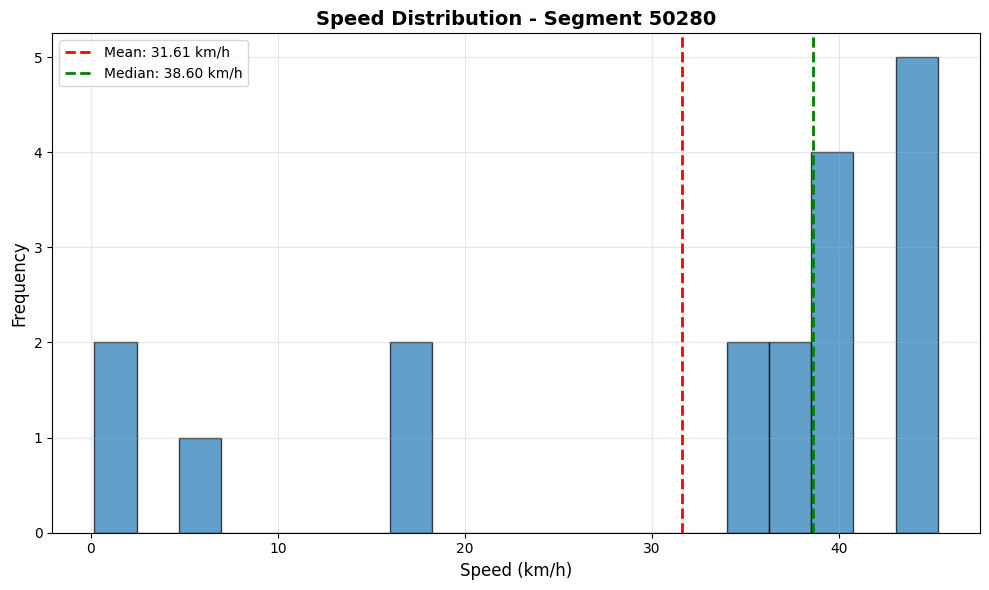

In [81]:
# Speed distribution histogram (using clean data without NaN)
segment_clean = segment[segment['speed_kmh'].notna()].copy()

plt.figure(figsize=(10, 6))
plt.hist(segment_clean['speed_kmh'], bins=20, edgecolor='black', alpha=0.7)
mean_speed = segment_clean['speed_kmh'].mean()
median_speed = segment_clean['speed_kmh'].median()
plt.axvline(mean_speed, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_speed:.2f} km/h')
plt.axvline(median_speed, color='g', linestyle='--', linewidth=2, label=f'Median: {median_speed:.2f} km/h')
plt.xlabel('Speed (km/h)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Speed Distribution - Segment {selected_segment_id}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Step 7: Geographic Visualization (Optional)

Plot the segment path on a simple coordinate plot.

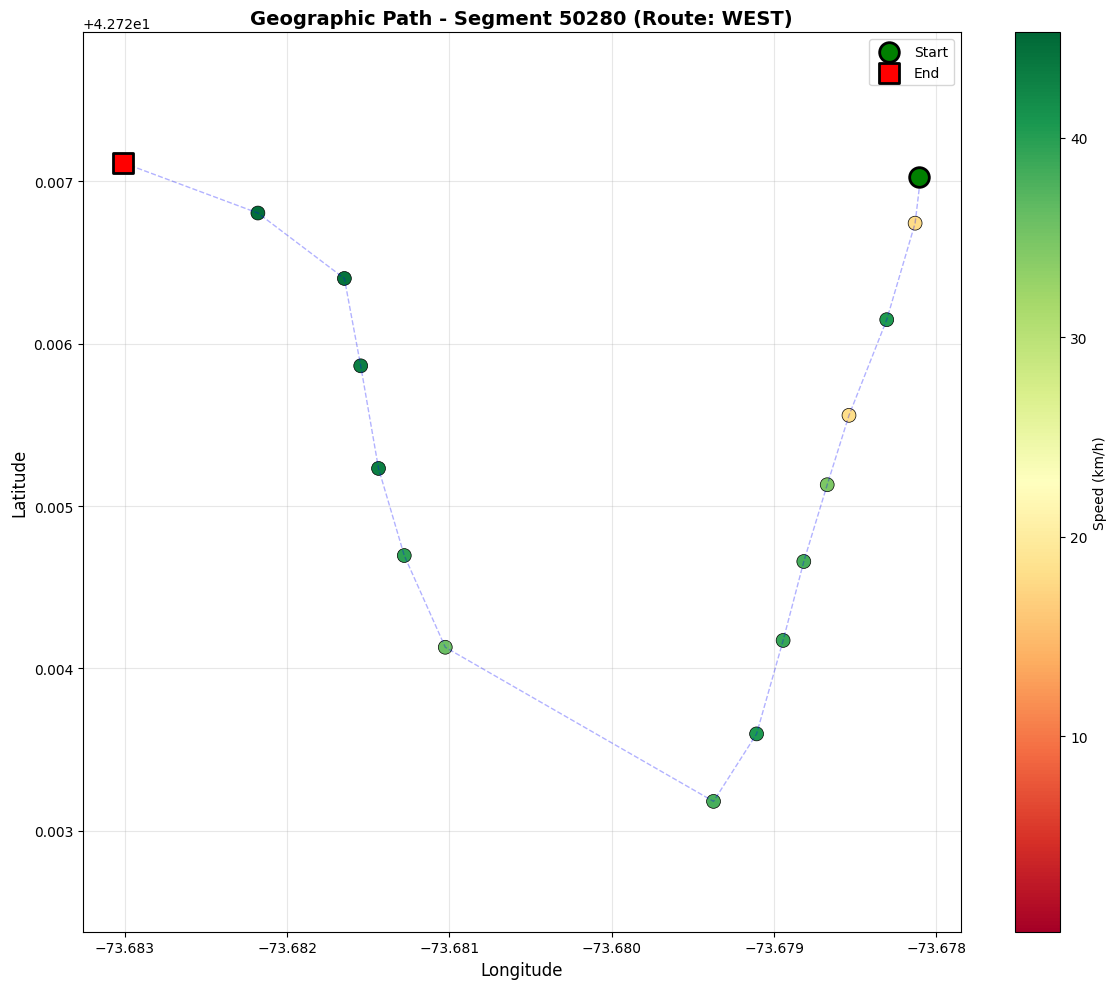

In [82]:
# Plot the geographic path with speed as color (using clean data without NaN)
segment_clean = segment[segment['speed_kmh'].notna()].copy()

plt.figure(figsize=(12, 10))

# Create a scatter plot with speed as color
scatter = plt.scatter(segment_clean['longitude'], segment_clean['latitude'],
                     c=segment_clean['speed_kmh'], cmap='RdYlGn',
                     s=100, edgecolors='black', linewidth=0.5)

# Add line connecting the points
plt.plot(segment_clean['longitude'], segment_clean['latitude'],
         color='blue', alpha=0.3, linewidth=1, linestyle='--')

# Mark start and end
plt.scatter(segment_clean['longitude'].iloc[0], segment_clean['latitude'].iloc[0],
           color='green', s=200, marker='o', edgecolors='black', linewidth=2, label='Start', zorder=5)
plt.scatter(segment_clean['longitude'].iloc[-1], segment_clean['latitude'].iloc[-1],
           color='red', s=200, marker='s', edgecolors='black', linewidth=2, label='End', zorder=5)

plt.colorbar(scatter, label='Speed (km/h)')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title(f'Geographic Path - Segment {selected_segment_id} (Route: {segment["route"].iloc[0]})',
         fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:
1. ✓ Loading preprocessed vehicle location data
2. ✓ Segmenting data into consecutive trips
3. ✓ Visualizing speed over time for a single segment
4. ✓ Analyzing speed distribution and geographic path
5. ✓ **ETA analysis with stop information** (see below)

The preprocessing pipeline handles:
- Timestamp conversion to epoch seconds
- Route matching using closest point algorithm
- Distance calculation between consecutive points
- Speed calculation from distance and time
- Segmentation based on vehicle ID and time gaps
- Stop detection and ETA calculation

In [83]:
# Run the ETA pipeline (handles segmentation, stop detection, filtering, and ETA calculation)
from ml.pipelines import stops_pipeline

print("="*70)
print("RUNNING ETA PIPELINE")
print("="*70)
stops_df = stops_pipeline()

print(f"\nFinal ETA data:")
print(f"  Total points: {len(stops_df):,}")
print(f"  Total segments: {stops_df['segment_id'].nunique():,}")
print(f"\nColumns in ETA data:")
print(f"  {list(stops_df.columns)}")

# Display sample data
print(f"\nSample data with stop and ETA information:")
stops_df[['timestamp', 'vehicle_id', 'route', 'stop_name', 'stop_route', 'eta_seconds', 'speed_kmh']].head(20)

RUNNING ETA PIPELINE
Loading stops preprocessed data from /Users/joel/eclipse-workspace/shuttletracker-new/ml/cache/shared/stops_preprocessed_max_distance0p005_max_timedelta30_min_segment_length3_window_size5.csv
Loaded 1047368 records from cache

Final ETA data:
  Total points: 1,047,368
  Total segments: 84,233

Columns in ETA data:
  ['vehicle_id', 'latitude', 'longitude', 'timestamp', 'epoch_seconds', 'dist_to_route', 'route', 'closest_lat', 'closest_lon', 'polyline_idx', 'segment_idx', 'segment_id', 'distance_km', 'speed_kmh', 'stop_route', 'stop_name', 'limit_indices', 'eta_seconds', 'dist_from_start', 'dist_to_end', 'polyline_length']

Sample data with stop and ETA information:


,timestamp,vehicle_id,route,stop_name,stop_route,eta_seconds,speed_kmh
0,2025-08-23 18:22:51.001,212014918466445,NORTH,NaN,NaN,110.040,NaN
1,2025-08-23 18:22:56.134,212014918466445,NORTH,NaN,NaN,104.907,25.140894
2,2025-08-23 18:23:02.038,212014918466445,NORTH,NaN,NaN,99.003,NaN
3,2025-08-23 18:23:16.052,212014918466445,NORTH,NaN,NaN,84.989,NaN
4,2025-08-23 18:23:23.566,212014918466445,NORTH,NaN,NaN,77.475,NaN
5,2025-08-23 18:23:36.056,212014918466445,NORTH,NaN,NaN,64.985,NaN
6,2025-08-23 18:23:54.333,212014918466445,NORTH,NaN,NaN,46.708,NaN
7,2025-08-23 18:24:18.054,212014918466445,NaN,NaN,NaN,22.987,NaN
8,2025-08-23 18:24:24.259,212014918466445,NaN,NaN,NaN,16.782,NaN
9,2025-08-23 18:24:36.004,212014918466445,NaN,NaN,NaN,5.037,NaN


In [84]:
# Analyze the ETA pipeline results
print("="*70)
print("ETA PIPELINE STATISTICS")
print("="*70)

# Stop information
points_with_stops = stops_df['stop_name'].notna().sum()
points_without_stops = stops_df['stop_name'].isna().sum()
print(f"\nStop Detection:")
print(f"  Points at stops: {points_with_stops:,} ({points_with_stops/len(stops_df)*100:.2f}%)")
print(f"  Points not at stops: {points_without_stops:,} ({points_without_stops/len(stops_df)*100:.2f}%)")
print(f"  Unique stops visited: {stops_df['stop_name'].nunique()}")
# List all unique stops
print(f"\nAll stops in dataset:")
for stop in sorted(stops_df['stop_name'].dropna().unique()):
    count = (stops_df['stop_name'] == stop).sum()
    print(f"  - {stop}: {count:,} visits")

# ETA information
eta_calculated = stops_df['eta_seconds'].notna().sum()
eta_null = stops_df['eta_seconds'].isna().sum()
print(f"\nETA Calculation:")
print(f"  ETAs calculated: {eta_calculated:,} ({eta_calculated/len(stops_df)*100:.2f}%)")
print(f"  NULL ETAs: {eta_null:,} ({eta_null/len(stops_df)*100:.2f}%)")
print(f"  (NULL ETAs occur after the last stop in each segment)")

# ETA statistics
eta_values = stops_df['eta_seconds'].dropna()
print(f"\nETA Distribution (seconds):")
print(eta_values.describe())
print(f"\nETA Distribution (minutes):")
print((eta_values / 60).describe())

# Segment information
segments_in_eta_data = stops_df['segment_id'].nunique()
print(f"\nSegments in ETA data: {segments_in_eta_data:,}")
print(f"  (These are segments that passed through at least one stop)")

# Compare to original segmented data
original_df = segment_pipeline()
original_segments = original_df['segment_id'].nunique()
filtered_segments = original_segments - segments_in_eta_data
print(f"\nSegment Filtering:")
print(f"  Original segments (from segment_pipeline): {original_segments:,}")
print(f"  Segments with stops (in ETA data): {segments_in_eta_data:,} ({segments_in_eta_data/original_segments*100:.2f}%)")
print(f"  Segments filtered out (no stops): {filtered_segments:,} ({filtered_segments/original_segments*100:.2f}%)")

ETA PIPELINE STATISTICS

Stop Detection:
  Points at stops: 367,508 (35.09%)
  Points not at stops: 679,860 (64.91%)
  Unique stops visited: 15

All stops in dataset:
  - ACADEMY_HALL: 17,707 visits
  - BLITMAN: 28,086 visits
  - CHASAN: 17,476 visits
  - CITY_STATION: 29,986 visits
  - COLONIE: 16,219 visits
  - ECAV: 12,839 visits
  - FEDERAL_6TH: 21,456 visits
  - GEORGIAN: 4,658 visits
  - HOUSTON_FIELD_HOUSE: 14,352 visits
  - POLYTECHNIC: 30,737 visits
  - STAC_1: 5,667 visits
  - STAC_2: 5,877 visits
  - STAC_3: 16,651 visits
  - STUDENT_UNION: 114,907 visits
  - WEST_HALL: 30,890 visits

ETA Calculation:
  ETAs calculated: 963,132 (91.96%)
  NULL ETAs: 84,236 (8.04%)
  (NULL ETAs occur after the last stop in each segment)

ETA Distribution (seconds):
count    963132.000000
mean         33.329413
std          33.585778
min           0.001000
25%           9.000000
50%          21.974000
75%          46.065000
max         384.997000
Name: eta_seconds, dtype: float64

ETA Distribu

## Step 9: Visualize ETA for a Segment with Stops

In [85]:
# Find a segment with multiple stops for better visualization
segment_stop_counts = stops_df.groupby('segment_id')['stop_name'].apply(lambda x: x.notna().sum())
segments_with_multiple_stops = segment_stop_counts[segment_stop_counts >= 2].index

if len(segments_with_multiple_stops) > 0:
    # Select a segment from the middle
    selected_eta_segment_id = segments_with_multiple_stops[len(segments_with_multiple_stops) // 2]
else:
    # Fallback to any segment with at least one stop
    segments_with_stops = segment_stop_counts[segment_stop_counts >= 1].index
    selected_eta_segment_id = segments_with_stops[len(segments_with_stops) // 2] if len(segments_with_stops) > 0 else stops_df['segment_id'].iloc[0]

# Extract the segment
eta_segment = stops_df[stops_df['segment_id'] == selected_eta_segment_id].copy()
eta_segment = eta_segment.sort_values('timestamp').reset_index(drop=True)

print(f"Selected segment {selected_eta_segment_id} for ETA visualization")
print(f"Number of points: {len(eta_segment)}")
print(f"Points at stops: {eta_segment['stop_name'].notna().sum()}")
print(f"Unique stops visited: {eta_segment['stop_name'].nunique()}")
print(f"ETAs calculated: {eta_segment['eta_seconds'].notna().sum()}")
print(f"Route: {eta_segment['route'].iloc[0]}")
print(f"\nStops in this segment:")
stops_in_segment = eta_segment[eta_segment['stop_name'].notna()][['timestamp', 'stop_name', 'stop_route']].drop_duplicates()
for idx, row in stops_in_segment.iterrows():
    print(f"  - {row['stop_name']} ({row['stop_route']}) at {row['timestamp']}")

# Display segment with ETA information
print(f"\nSegment data with ETAs:")
eta_segment[['timestamp', 'latitude', 'longitude', 'stop_name', 'eta_seconds', 'speed_kmh']].head(20)

Selected segment 230910 for ETA visualization
Number of points: 6
Points at stops: 3
Unique stops visited: 1
ETAs calculated: 5
Route: WEST

Stops in this segment:
  - FEDERAL_6TH (WEST) at 2025-10-20 19:22:30.079000
  - FEDERAL_6TH (WEST) at 2025-10-20 19:22:35.010000
  - FEDERAL_6TH (WEST) at 2025-10-20 19:22:47.013000

Segment data with ETAs:


,timestamp,latitude,longitude,stop_name,eta_seconds,speed_kmh
0,2025-10-20 19:22:13.010,42.732376,-73.686173,NaN,17.069,NaN
1,2025-10-20 19:22:18.075,42.732753,-73.686067,NaN,12.004,30.662508
2,2025-10-20 19:22:24.035,42.733232,-73.685971,NaN,6.044,31.504743
3,2025-10-20 19:22:30.079,42.733508,-73.685685,FEDERAL_6TH,4.931,NaN
4,2025-10-20 19:22:35.010,42.733532,-73.685664,FEDERAL_6TH,12.003,NaN
5,2025-10-20 19:22:47.013,42.733552,-73.685675,FEDERAL_6TH,NaN,NaN


Loading segmented data from /Users/joel/eclipse-workspace/shuttletracker-new/ml/cache/shared/locations_segmented_max_distance0p005_max_timedelta15_min_segment_length3_window_size5.csv
Loaded 1435917 records from cache


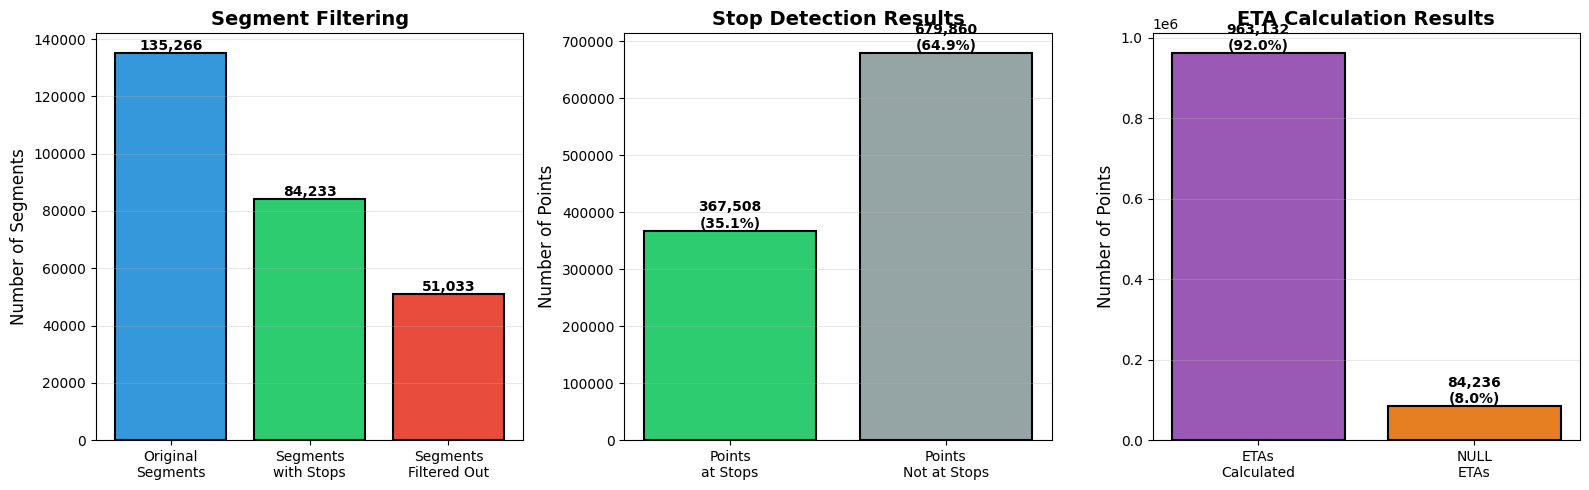


ETA PIPELINE SUMMARY
Original segments:              135,266
Segments with stops:            84,233 (62.3%)
Segments filtered out:          51,033 (37.7%)

Total points in ETA data:       1,047,368
Points at stops:                367,508 (35.1%)
Points not at stops:            679,860 (64.9%)

ETAs calculated:                963,132 (92.0%)
NULL ETAs:                      84,236 (8.0%)


In [86]:
# Summary visualization: ETA Pipeline Results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Get original segment count for comparison
original_df = segment_pipeline()
original_segments = original_df['segment_id'].nunique()
segments_in_eta = stops_df['segment_id'].nunique()
segments_filtered = original_segments - segments_in_eta

# Get statistics
points_with_stops = stops_df['stop_name'].notna().sum()
points_without_stops = stops_df['stop_name'].isna().sum()
eta_calculated = stops_df['eta_seconds'].notna().sum()
eta_null = stops_df['eta_seconds'].isna().sum()

# Plot 1: Segment filtering
ax1 = axes[0]
segment_categories = ['Original\nSegments', 'Segments\nwith Stops', 'Segments\nFiltered Out']
segment_counts = [original_segments, segments_in_eta, segments_filtered]
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars1 = ax1.bar(segment_categories, segment_counts, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of Segments', fontsize=12)
ax1.set_title('Segment Filtering', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Points at stops vs not at stops
ax2 = axes[1]
point_categories = ['Points\nat Stops', 'Points\nNot at Stops']
point_counts = [points_with_stops, points_without_stops]
colors2 = ['#2ecc71', '#95a5a6']
bars2 = ax2.bar(point_categories, point_counts, color=colors2, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Number of Points', fontsize=12)
ax2.set_title('Stop Detection Results', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels and percentages
for bar, count in zip(bars2, point_counts):
    height = bar.get_height()
    percentage = count / len(stops_df) * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count):,}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: ETA calculation results
ax3 = axes[2]
eta_categories = ['ETAs\nCalculated', 'NULL\nETAs']
eta_counts = [eta_calculated, eta_null]
colors3 = ['#9b59b6', '#e67e22']
bars3 = ax3.bar(eta_categories, eta_counts, color=colors3, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Number of Points', fontsize=12)
ax3.set_title('ETA Calculation Results', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add value labels and percentages
for bar, count in zip(bars3, eta_counts):
    height = bar.get_height()
    percentage = count / len(stops_df) * 100
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count):,}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ETA PIPELINE SUMMARY")
print("="*70)
print(f"Original segments:              {original_segments:,}")
print(f"Segments with stops:            {segments_in_eta:,} ({segments_in_eta/original_segments*100:.1f}%)")
print(f"Segments filtered out:          {segments_filtered:,} ({segments_filtered/original_segments*100:.1f}%)")
print(f"\nTotal points in ETA data:       {len(stops_df):,}")
print(f"Points at stops:                {points_with_stops:,} ({points_with_stops/len(stops_df)*100:.1f}%)")
print(f"Points not at stops:            {points_without_stops:,} ({points_without_stops/len(stops_df)*100:.1f}%)")
print(f"\nETAs calculated:                {eta_calculated:,} ({eta_calculated/len(stops_df)*100:.1f}%)")
print(f"NULL ETAs:                      {eta_null:,} ({eta_null/len(stops_df)*100:.1f}%)")
print("="*70)

In [87]:
# display the segment with the maximum eta
max_eta_idx = stops_df['eta_seconds'].idxmax()
segment_with_max_eta = stops_df[stops_df['segment_id'] == stops_df.loc[max_eta_idx, 'segment_id']].copy()
segment_with_max_eta = segment_with_max_eta.sort_values('timestamp')
segment_with_max_eta

,vehicle_id,latitude,longitude,timestamp,epoch_seconds,dist_to_route,route,closest_lat,closest_lon,polyline_idx,...,segment_id,distance_km,speed_kmh,stop_route,stop_name,limit_indices,eta_seconds,dist_from_start,dist_to_end,polyline_length
132104,281474977371235,42.732045,-73.670624,2025-11-08 23:31:54.027,2.695511e+07,0.003203,NORTH,42.732032,-73.670659,7.0,...,49047,NaN,NaN,NaN,NaN,179322.0,384.997,0.089756,0.806733,0.896488
132105,281474977371235,42.732043,-73.670636,2025-11-08 23:32:03.021,2.695512e+07,0.002242,NORTH,42.732032,-73.670659,7.0,...,49047,0.000000,0.000000,NaN,NaN,179322.0,376.003,0.089756,0.806733,0.896488
132106,281474977371235,42.732049,-73.670641,2025-11-08 23:32:17.027,2.695514e+07,0.002128,NORTH,42.732038,-73.670662,7.0,...,49047,0.000686,0.176404,NaN,NaN,179322.0,361.997,0.090442,0.806046,0.896488
132107,281474977371235,42.732160,-73.670716,2025-11-08 23:32:39.022,2.695516e+07,0.000894,NORTH,42.732155,-73.670725,7.0,...,49047,0.014038,2.297723,NaN,NaN,179322.0,340.002,0.104480,0.792008,0.896488
132108,281474977371235,42.732322,-73.670856,2025-11-08 23:32:44.180,2.695516e+07,0.004017,NORTH,42.732289,-73.670876,7.0,...,49047,0.019327,13.488946,NaN,NaN,179322.0,334.844,0.124303,0.772186,0.896488
132109,281474977371235,42.732380,-73.671302,2025-11-08 23:32:50.047,2.695517e+07,0.002807,NORTH,42.732355,-73.671305,7.0,...,49047,0.035830,21.985612,NaN,NaN,179322.0,328.977,0.160151,0.736337,0.896488
132110,281474977371235,42.732527,-73.672447,2025-11-08 23:33:13.998,2.695519e+07,0.002740,NORTH,42.732502,-73.672450,7.0,...,49047,0.094927,14.268153,NaN,NaN,179322.0,305.026,0.255080,0.641408,0.896488
132111,281474977371235,42.732534,-73.672572,2025-11-08 23:33:24.006,2.695520e+07,0.001742,NORTH,42.732518,-73.672574,7.0,...,49047,0.010270,3.694112,NaN,NaN,179322.0,295.018,0.265350,0.631138,0.896488
132112,281474977371235,42.732534,-73.672571,2025-11-08 23:33:29.060,2.695521e+07,0.001756,NORTH,42.732518,-73.672573,7.0,...,49047,0.000082,0.058102,NaN,NaN,179322.0,289.964,0.265268,0.631220,0.896488
132113,281474977371235,42.732541,-73.672616,2025-11-08 23:33:34.044,2.695521e+07,0.001888,NORTH,42.732524,-73.672618,7.0,...,49047,0.003744,2.704408,NaN,NaN,179322.0,284.980,0.269012,0.627476,0.896488


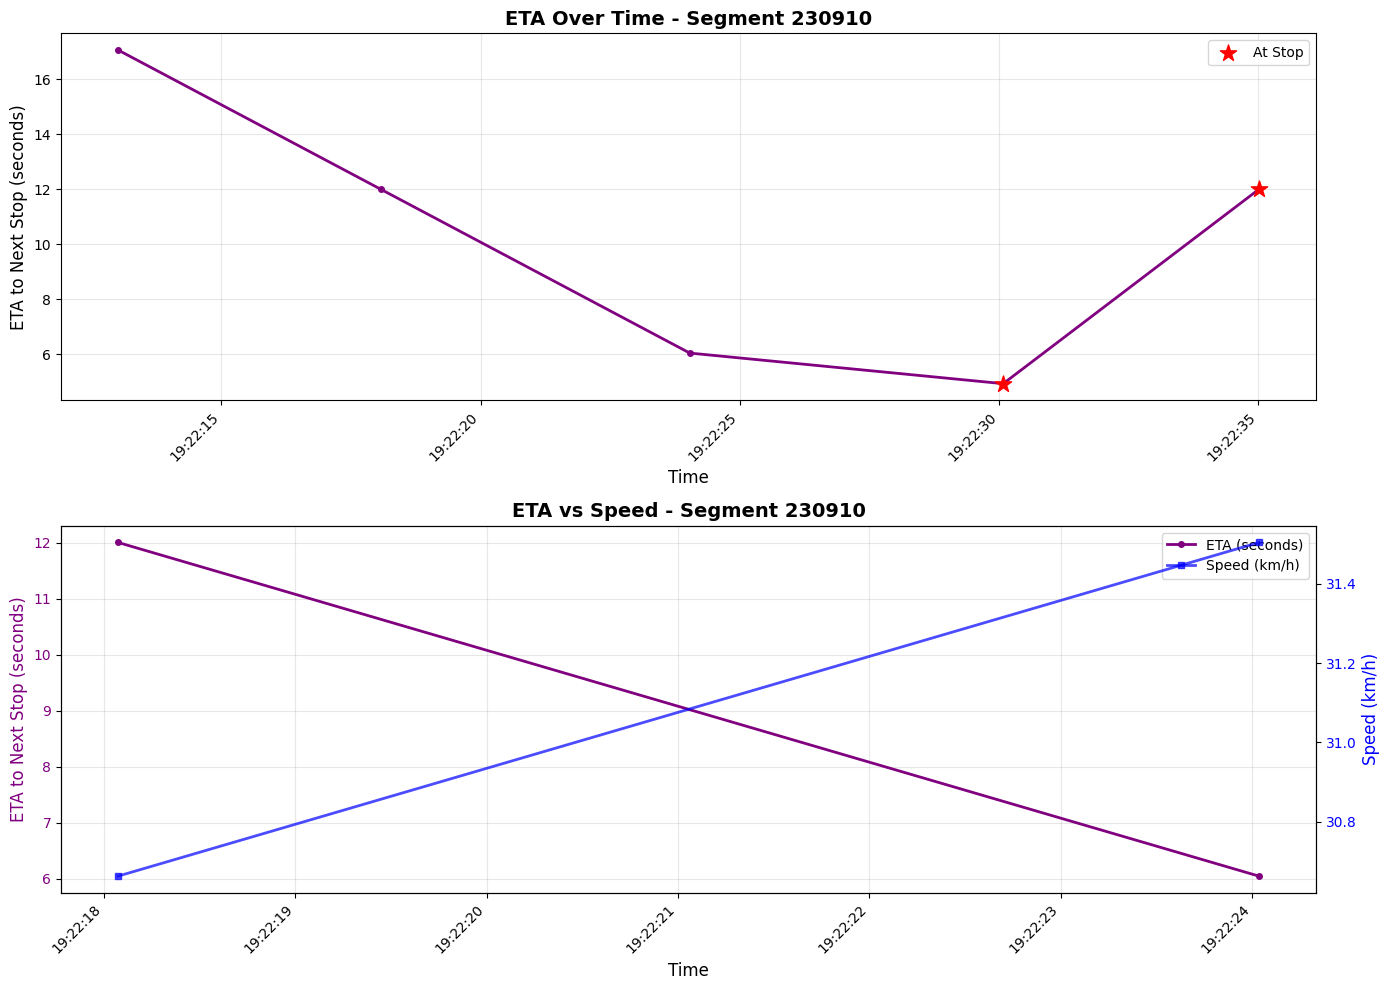


ETA Statistics for Segment 230910:
  Mean ETA: 10.41 seconds (0.17 minutes)
  Median ETA: 12.00 seconds (0.20 minutes)
  Max ETA: 17.07 seconds (0.28 minutes)
  Min ETA: 4.93 seconds (0.08 minutes)


In [88]:
# Visualize ETA over time
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Filter to points with ETAs
eta_segment_clean = eta_segment[eta_segment['eta_seconds'].notna()].copy()

# Plot 1: ETA to next stop over time
ax1 = axes[0]
ax1.plot(eta_segment_clean['timestamp'], eta_segment_clean['eta_seconds'],
         marker='o', linestyle='-', linewidth=2, markersize=4, color='purple')
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('ETA to Next Stop (seconds)', fontsize=12)
ax1.set_title(f'ETA Over Time - Segment {selected_eta_segment_id}', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Highlight points at stops
stops_mask = eta_segment_clean['stop_name'].notna()
if stops_mask.any():
    ax1.scatter(eta_segment_clean[stops_mask]['timestamp'],
               eta_segment_clean[stops_mask]['eta_seconds'],
               color='red', s=150, marker='*', label='At Stop', zorder=5)
    ax1.legend()

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: ETA vs Speed
ax2 = axes[1]
# Filter to points with both ETA and speed
plot_data = eta_segment[(eta_segment['eta_seconds'].notna()) & (eta_segment['speed_kmh'].notna())].copy()

if len(plot_data) > 0:
    ax2_twin = ax2.twinx()

    # Plot ETA on left y-axis
    line1 = ax2.plot(plot_data['timestamp'], plot_data['eta_seconds'],
                     marker='o', linestyle='-', linewidth=2, markersize=4,
                     color='purple', label='ETA (seconds)')
    ax2.set_ylabel('ETA to Next Stop (seconds)', fontsize=12, color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')

    # Plot speed on right y-axis
    line2 = ax2_twin.plot(plot_data['timestamp'], plot_data['speed_kmh'],
                          marker='s', linestyle='-', linewidth=2, markersize=4,
                          color='blue', label='Speed (km/h)', alpha=0.7)
    ax2_twin.set_ylabel('Speed (km/h)', fontsize=12, color='blue')
    ax2_twin.tick_params(axis='y', labelcolor='blue')

    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_title(f'ETA vs Speed - Segment {selected_eta_segment_id}', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)

    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, loc='upper right')

    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Statistics
if len(eta_segment_clean) > 0:
    print(f"\nETA Statistics for Segment {selected_eta_segment_id}:")
    print(f"  Mean ETA: {eta_segment_clean['eta_seconds'].mean():.2f} seconds ({eta_segment_clean['eta_seconds'].mean()/60:.2f} minutes)")
    print(f"  Median ETA: {eta_segment_clean['eta_seconds'].median():.2f} seconds ({eta_segment_clean['eta_seconds'].median()/60:.2f} minutes)")
    print(f"  Max ETA: {eta_segment_clean['eta_seconds'].max():.2f} seconds ({eta_segment_clean['eta_seconds'].max()/60:.2f} minutes)")
    print(f"  Min ETA: {eta_segment_clean['eta_seconds'].min():.2f} seconds ({eta_segment_clean['eta_seconds'].min()/60:.2f} minutes)")

## Conclusions

The ETA pipeline analysis shows:
- **Stop Detection**: A significant portion of segments pass through known stops
- **Segment Filtering**: Segments without any stops are filtered out, focusing the dataset on meaningful trip segments
- **ETA Calculation**: Most points have valid ETAs to the next stop, with NULL values primarily occurring after the final stop in each segment
- **Data Quality**: The pipeline effectively identifies stops and calculates realistic ETAs that can be used for machine learning prediction tasks

The data is now ready for LSTM and ARIMA model training!